# Seattle Airbnb Open Data

Before the whole COVID-19 start, I was looking into booking a few places to visit around Washington state incluing Seattle and Whibdey island. As I was looking for place I could see that prices vary significantly from city to city and from neighborhood to another.

The current [data](https://www.kaggle.com/airbnb/seattle) at hand, only contains information about the city of Seattle. Let's see what information we can find about the data and how we can predict the price of a rental based on its description and any data available in this set.

## 1. Business Understanding

* Host experience: As I was talking to a friend of mine we were thinking that perhaps more experienced hosts charge more for their listings. Is that true? It seems intuitive that as you get more customer and expand, you can also charge more. What does the data tell us?

* Is there a correlation with the date of a reservation and the price?

* Is there any useful information in the neighborhood and municipality about the unit price?

* What are the most determining factors in the price of a unit?


Let's import the necessary libraries

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import seaborn
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

Load data

In [2]:
path = 'seattle/'
df = pd.read_csv(path + 'listings.csv')
calendar = pd.read_csv(path + 'calendar.csv')
reviews = pd.read_csv(path + 'reviews.csv')

## 2. Data Understanding

Here are the steps for cleaning the data.

1. Drop nan values
2. Extract feature from dates, such as day of the week and week of the year
3. Turn date strings into numbers for year, month, and day
4. Turn price (string with dollar sign) to number

In [3]:
def convert_time(dataframe, name):
    """
    This function takes a dataframe as an input, plus the name of the date column. Then splits the date by '-', 
    and converts to year, month, and day. It also extracts day of the week and week of the year as features.
    
    Args:
    dataframe (pandas.DataFrame): the input dataframe
    name (str): the name of the column to be treated as date string
    
    Returns:
    pd.DataFrame: with new columns for year, month, day, dayofweek, and weekofyear
    """
    to_numeric = lambda x: float(x.lstrip('$').replace(',', ''))
    suffixes = ['y', 'm', 'd']
    date = pd.to_datetime(dataframe[name])
    dataframe['dayofweek'] = date.dt.dayofweek
    dataframe['weekofyear'] = date.dt.week
    split_df = dataframe[name].str.split('-', expand=True).rename(columns={idx: '%s_%s' % (name, suffix) for idx, suffix in enumerate(suffixes)}).applymap(float)
    dataframe = pd.concat((dataframe.drop([name], axis=1), split_df), axis=1)
    dataframe['price'] = dataframe.price.apply(to_numeric)
    return dataframe
    
calendar.dropna(inplace=True)
df = df.applymap(lambda x: str.lower(x) if isinstance(x, str) else x)

calendar = convert_time(calendar, 'date')
df = convert_time(df, 'host_since')

### Neighborhood and Municipality
Before we go any further, let's answer the first question, is there any information about the city and municipality?

Looking at the data below you can see that there are three columns with the name seattle. One was capitalized, and in the cell above as I lower-cased each string, they become the same. The third one is in Chinese characters. Despite being the same city, the mean values for price are wildly different. Perhaps the Seattle value in Chinese character is a special type of unit for visiting students? I have no idea. I don't think much information can be drawn from the city field.

In [4]:
city_data = df.groupby('city')['price']
city_data.mean()

city
ballard, seattle         116.000000
phinney ridge seattle     60.000000
seattle                  128.046182
seattle                   97.500000
west seattle             110.000000
西雅图                       38.000000
Name: price, dtype: float64

Let's look at neighborhood instead. Let's pull all columns that has neighborhood in them.

In [5]:
df[[x for x in df.columns if 'neighb' in x]]

,neighborhood_overview,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,NaN,queen anne,queen anne,west queen anne,queen anne
1,"queen anne is a wonderful, truly functional vi...",queen anne,queen anne,west queen anne,queen anne
2,upper queen anne is a charming neighborhood fu...,queen anne,queen anne,west queen anne,queen anne
3,NaN,queen anne,queen anne,west queen anne,queen anne
4,we are in the beautiful neighborhood of queen ...,queen anne,queen anne,west queen anne,queen anne
...,...,...,...,...,...
3813,we're located near lots of family fun. woodlan...,holly,fremont,fremont,other neighborhoods
3814,the neighborhood is a quiet oasis that is clos...,portage bay,portage bay,portage bay,capitol hill
3815,NaN,NaN,NaN,rainier beach,rainier valley
3816,madison park offers a peaceful slow pace upsca...,NaN,NaN,madison park,capitol hill


It appears that the best column to look at is "neighbourhood_group_cleansed"

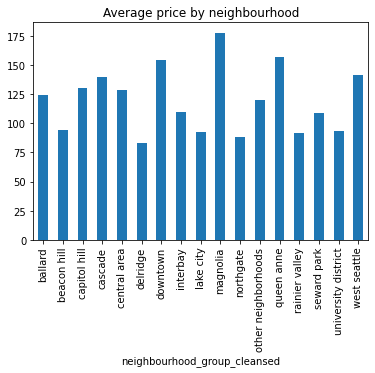

In [6]:
relevant_data = df.groupby('neighbourhood_group_cleansed')[['price', 'longitude', 'latitude']].mean()
relevant_data['price'].plot.bar(title="Average price by neighbourhood")

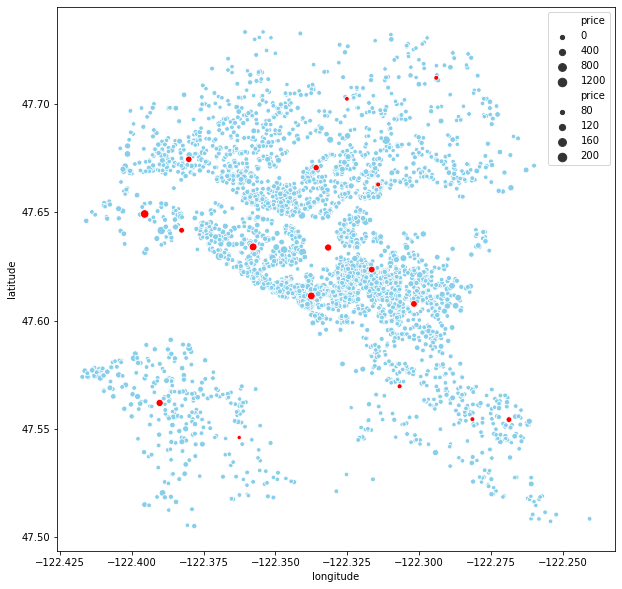

In [7]:
plt.figure(figsize=(10, 10))
seaborn.scatterplot(data=df, x='longitude', y='latitude', size='price', marker='o', color='skyblue')
seaborn.scatterplot(data=relevant_data, x='longitude', y='latitude', size='price', marker='o', color='red')

### Host experience

How does the host experience correlate with listing price?

By inspecting the heatmap below, we can see that there is a small correlation with the year the host started renting Airbnb unit and the unit price. This correlation is slightly negative, which means that if the host joined sooner (smaller year) the price is slightly higher.

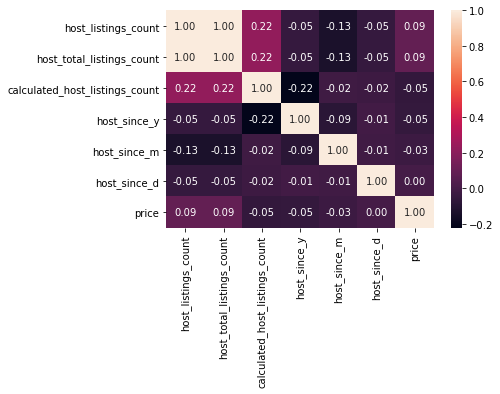

In [8]:
data = df[[x for x in df.columns if 'host' in x] + ['price']].drop(['host_id'], axis=1)
seaborn.heatmap(data.corr(), fmt='.2f', annot=True)

Below in the bar plot, we can see that hosts who joined in 2008-2009 have relatively cheaper units, which explains why the overall correlation is small. Plus, the standard error on these averages is high, which also diminishes correlations.

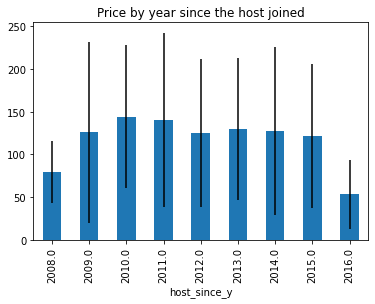

In [9]:
df.groupby('host_since_y')['price'].mean().plot.bar(title='Price by year since the host joined', yerr=df.groupby('host_since_y')['price'].std())

### Date of reservation

By looking at the correlation of we can see, not surprisingly, that the reservation price has a slight correlation the day of week and month. It has little dependence on the year of the reservation. Given the symmetric nature of the demand that peaks in the middle of summer, there is little difference between month and week of the year. In other words, month is the stronger indicator, and week of the year just follows month. If there was strong week-to-week variation within a month, then week would have been an important feature.

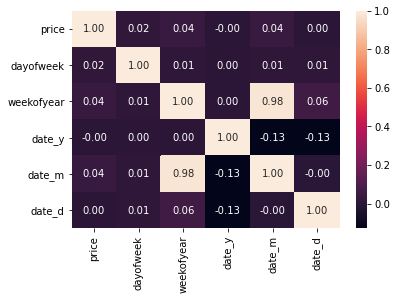

In [10]:
seaborn.heatmap(calendar.drop('listing_id', axis=1).corr(), fmt='.2f', annot=True)

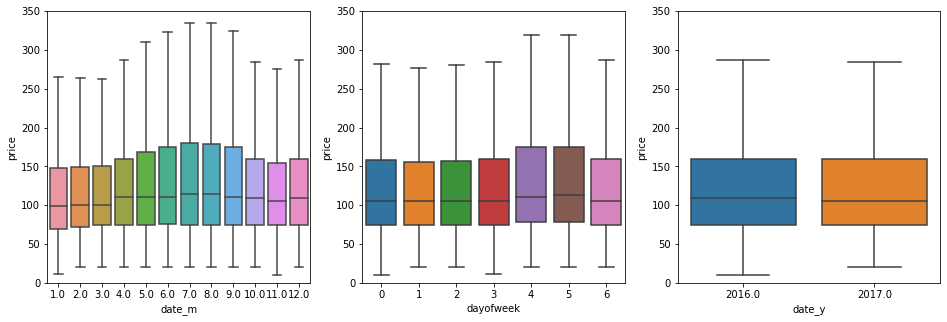

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
seaborn.boxplot(data=calendar, x='date_m', y='price', ax=axs[0], fliersize=0)
seaborn.boxplot(data=calendar, x='dayofweek', y='price', ax=axs[1], fliersize=0)
seaborn.boxplot(data=calendar, x='date_y', y='price', ax=axs[2], fliersize=0)
for ax in axs:
    ax.set_ylim(0, 350)

## 3. Prepare Data

Let's put the columns in different categories. 

* Remove columns with 'id' and 'url' in their names.
* Keep the numeric columns.
* If columns are objects, see how many unique values exist. If the number of unique elements is limited, we can treat it as a categorical variable.
* If only one values exist, there is no information, drop it.
* Create dummy one-hot variables from categorical ones.
* If there are more than 20% null values, drop the column
* If there are less than 20%, fill with mean value

In [ ]:
def group_columns(df):
    """
    This function takes a dataframe and groups the columns by their characteristics.
    This is relatively a general function and reusable on other datasets
    
    Args:
    df (pandas.DataFrame): The input data frame
    
    Returns:
    dict: A dictionary of column types and list of columns
    """
    columns = df.columns
    columns_list = {'categorical': [], 'binary': [], 'text': [], 'number': [], 'drop': []}
    for col in columns:
        if col == 'id':
            continue
        elif 'id' in col or 'url' in col:
            columns_list['drop'].append(col)
        else:
            if df[col].dtype == np.dtype('O'):
                n = len(np.unique(df[col][df[col].notnull()]))
                if n == 1:
                    columns_list['drop'].append(col)
                elif n < 20:
                    columns_list['categorical'].append(col)
                else:
                    columns_list['text'].append(col)
            else:
                columns_list['number'].append(col)
    return columns_list

def clean_data(df):
    """
    This function cleans the input data frame by removing unwanted columns, turning categorical variables to 
    one-hot numbers, and dropping columns or filling NAN values based on the frequency of NAN in the columns.
    """
    df.drop(['city'], axis=1, inplace=True)
    columns_list = group_columns(df)

    df = df.drop(columns_list['drop'], axis=1)
    for col in columns_list['categorical']:
        dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
        columns_list['number'].extend(dummies.columns.tolist())
        assert(col not in df.columns)
    for col in columns_list['text']:
        df[col] = df[col].fillna('na')

    df_new = df[columns_list['number'] + ['id']]
    
    df_nan = df.isnull().mean()
    for col in df_new.columns:
        if df_nan[col] > 0.2:
            df_new.drop(col, axis=1, inplace=True)
        elif col in df_nan.index:
            df_new.fillna({col: df_new[col].mean()}, inplace=True)
    return df_new

df_new = clean_data(df)

* Merge the data two datasets


In [13]:
df = pd.merge(calendar.drop('available', axis=1), df_new, left_on='listing_id', right_on='id')

## 4. Data Modelling

Now that we have merged the data. Let's look at the variablity of the some of the remaining columns, and drop them if there is no information in them.

Then, we will, as usual, split the data into train and test to be able to evaluate our model. I'll simply pick random forest as a starting point with default values.

In [14]:
X = df.drop(['price_x', 'price_y', 'listing_id', 'id'], axis=1)
drop_more = [x for x in X.columns if X[x].std() <= 1e-6]
X.drop(drop_more, axis=1, inplace=True)
y = df['price_x']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = RandomForestRegressor()
model.fit(xtrain, ytrain)

ypred = model.predict(xtrain)
ypredtest = model.predict(xtest)

r2 = r2_score(ytrain, ypred)
r2test = r2_score(ytest, ypredtest)

print("Training r2-score: %.4f,  Test r2-score: %.4f" % (r2, r2test))

Training r2-score: 0.9996,  Test r2-score: 0.9970


Since the result is pretty good on our first try, I'll avoid further study of different models for now.

## 5. Evaluate the Results

In order to figure out the answer to this question, one way is to look at the correlation of the top 10 important features with the unit price. In order to do that, we are going to sort the feature importance of our trained model and pick the data column that corresponds to the feature.

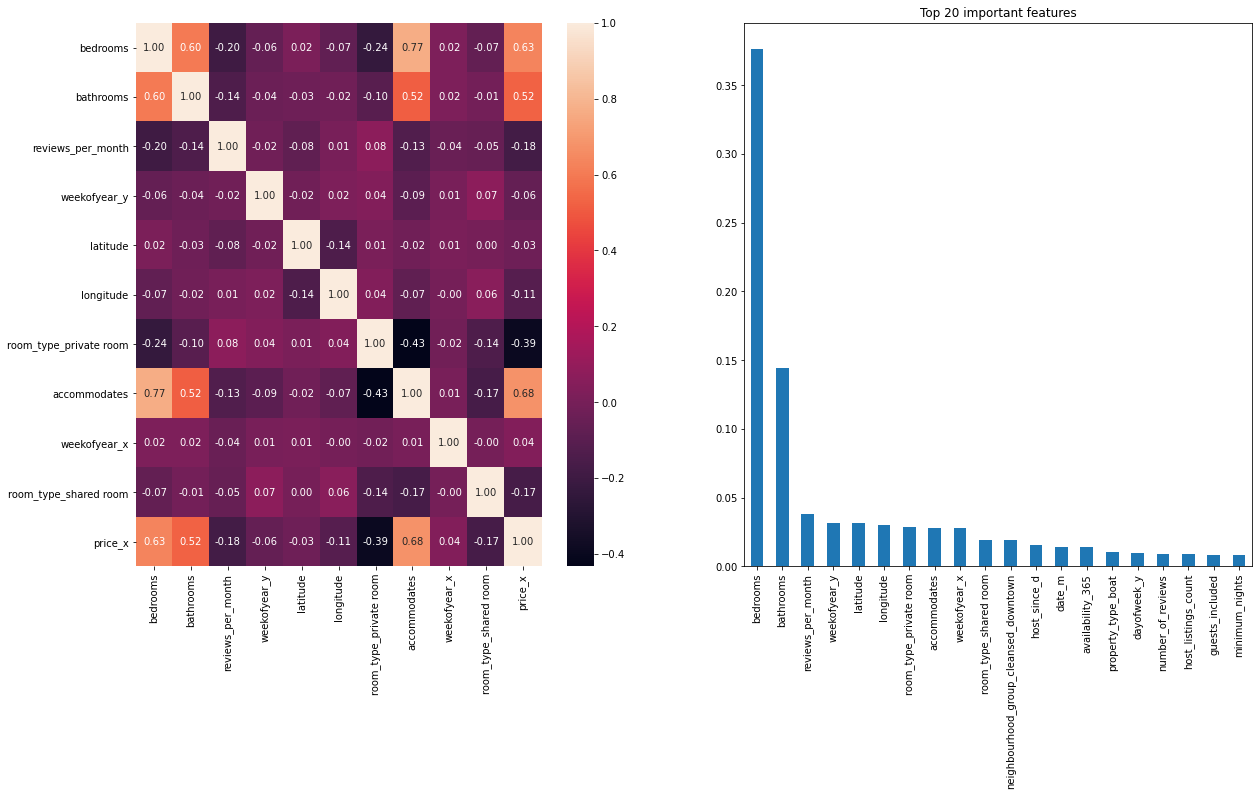

In [21]:
inds = np.argsort(-model.feature_importances_)
importance_ds = pd.Series(model.feature_importances_[inds][:20], index=X.columns[inds][:20])
cols = X.columns[inds][:10]
new_data = pd.concat((X[cols], y), axis=1)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
seaborn.heatmap(new_data.corr(), fmt='.2f', annot=True, ax=axs[0])
importance_ds.plot.bar(title='Top 20 important features', ax=axs[1])

## 6. Deploy

I used out of the box random forest for regression. It turned out that we can get a test R2 score of 99% by just using the default settings of the classifier with 100 estimators.
According to this model, the most contributing factors to listing price are the number of bedrooms, bathrooms, the number of people accommodated, and the location of the unit.
The next important consideration is whether the listing indicates the unit is a private room or a shared unit; otherwise, the prices are higher.
This analysis is city dependent, and different models need to be built for each city.

For more information please read [this](https://medium.com/@hosseinsadeghiesfahani/three-facts-about-airbnb-prices-4b9eb6a0fd0b) blog.